<a href="https://colab.research.google.com/github/leeyjin1/usb-serial-for-android/blob/master/cnn_multi_period_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN-Based Multivariate Time Series Prediction of Cycling Power and Energy Expenditure
dec 14 2023

The model allows training and inference on multi-variate, multi-step data.

The goal is to predict power at time t given data on speed, cadence, altitude, distance, etc., at time t to t-n.

The default available historical data are current time, t, to n time periods in the past.

Parameters are scaled based on expected maximum values. Unless otherwise noted, all variables have min value of zero.

The data matrix is reshaped to allow use with Keras.

TODO: separate long runs from climbs. seaparate train val and test based on evaluation of session (e.g. similar lengths)

TODO: include number of vehicles into X



In [ ]:
legend = {
    "timestamp": "",
    "position_lat": "GPS Latitude (deg)",
    "position_long": "GPS Longitude (deg)",
    "distance": "Distance (km)",
    "enhanced_speed": "Speed (m/sec)",
    "enhanced_altitude": "Altitude (m)",
    "power": "Power (W)",
    "heart_rate": "Heart Rate (BPM)",
    "cadence": "Cadence (RPM)",
    "temperature": "Temperature (C)",
    "gear_ratio": "Gear Ratio"
}

feature_max = {
    "enhanced_speed": 100,
    "enhanced_altitude": 1000,
    "heart_rate": 250,
    "cadence": 160,
    "temperature": 40,
    "enhanced_speed": 100,
    "gear_ratio": 6,
    "power": 1000
}

feature_cols=['enhanced_altitude', 'enhanced_speed', 'heart_rate', 'cadence']

Mount google drive and read in the data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import unique
from pandas import read_csv

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import Input

import os
import datetime
import glob
import re
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(base_dir, session_prefix):
    session_dirs = glob.glob(base_dir + '/' + session_prefix + '*') # bike data series

    first = True
    sess_boundary_timestamps = {}

    for i, sess_dir in enumerate(session_dirs):
        for fn in glob.glob(sess_dir + '/*_features.csv'):
            print(fn)
            sess_ts = re.search('\d{8}_\d{6}', fn.split('/')[-1].split('.')[0])
            if sess_ts is None:
                continue

            sess_ts = sess_ts.group(0)

            sess = pd.read_csv(fn)
            sess['timestamp'] = pd.to_datetime(sess['timestamp'])

            sess_boundary_timestamps[sess_ts] = [sess.timestamp.values[0], sess.timestamp.values[-1]]

            if first:
                if sess.shape[0] > 0:
                    df = sess
                    first = False
            else:
                df = pd.concat([df, sess])

    return df, sess_boundary_timestamps#X, y, sess_boundary_timestamps

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, n_step=1, dropnan=True):
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Modification of the function of the same name in Jin's colab notebook
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    header = df.columns.to_list()
    cols, names = list(), list()

    last = (n_in-1) // n_step
    # was: for i in range(n_in, 0, -1):
    for i in range(last*n_step, 0, -n_step):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (header[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % header[j]) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (header[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg = agg.dropna()
        # agg = agg.reset_index()

    # lim = n_in*(agg.shape[0] // n_in)
    # agg = agg.iloc[:lim]
    return agg

In [ ]:
def make_test_mask(X, test_date_str_list, sess_boundary_timestamps):
    # all_dates = set(map(lambda x: datetime.datetime.strptime(str(x), SESS_DT_OUTFMT).date(), sess_boundary_timestamps.keys()))
    # all_date_strs = list(map(lambda x: datetime.datetime.strftime(x, SESS_DATE_OUTFMT), all_dates))

    mask_test = np.array([False]*X.shape[0])

    for dstr in test_date_str_list:
        dt_start = datetime.datetime.strptime(dstr, '%Y-%m-%d')  #SESS_DATE_OUTFMT = '%Y-%m-%d'
        dt_end = dt_start + datetime.timedelta(days=1)

        mask_time = ((X['timestamp'] >= dt_start) & (X['timestamp'] < dt_end))
        mask_test = mask_test | mask_time

    return mask_test

In [ ]:
base_dir = '/content/drive/My Drive/WearDarpa/processed_data'
# session_dirs = glob.glob(base_dir + '/B*') # bike data series

sess, sess_boundary_timestamps = load_data(base_dir, 'B')
sess_boundary_timestamps

/content/drive/My Drive/WearDarpa/processed_data/B20231025_101117_0/B20231025_101117_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231028_092018_0/B20231028_092018_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231028_115903_0/B20231028_115903_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231028_133638_0/B20231028_133638_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231104_084648_0/B20231104_084648_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231104_111204_0/B20231104_111204_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231104_150012_0/B20231104_150012_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231104_162151_0/B20231104_162151_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231115_124402_0/B20231115_124402_features.csv
/content/drive/My Drive/WearDarpa/processed_data/B20231118_110313_0/B20231118_110313_features.csv
/content/drive/My Dr

{'20231025_101117': [numpy.datetime64('2023-10-25T10:11:26.000000000'),
  numpy.datetime64('2023-10-25T12:04:06.000000000')],
 '20231028_092018': [numpy.datetime64('2023-10-28T09:20:27.000000000'),
  numpy.datetime64('2023-10-28T11:28:07.000000000')],
 '20231028_115903': [numpy.datetime64('2023-10-28T11:59:12.000000000'),
  numpy.datetime64('2023-10-28T13:29:22.000000000')],
 '20231028_133638': [numpy.datetime64('2023-10-28T13:36:47.000000000'),
  numpy.datetime64('2023-10-28T16:22:27.000000000')],
 '20231104_084648': [numpy.datetime64('2023-11-04T08:46:57.000000000'),
  numpy.datetime64('2023-11-04T10:48:17.000000000')],
 '20231104_111204': [numpy.datetime64('2023-11-04T11:12:13.000000000'),
  numpy.datetime64('2023-11-04T14:34:23.000000000')],
 '20231104_150012': [numpy.datetime64('2023-11-04T15:00:21.000000000'),
  numpy.datetime64('2023-11-04T16:15:51.000000000')],
 '20231104_162151': [numpy.datetime64('2023-11-04T16:22:00.000000000'),
  numpy.datetime64('2023-11-04T18:04:30.000000

In [ ]:
bad_data_mask = sess['timestamp'].dt.date != datetime.date(2023, 9, 30)
dataset = sess[bad_data_mask]
dataset=dataset.sort_values(by="timestamp")
dataset.head()

,timestamp,position_lat,position_long,distance,enhanced_altitude,enhanced_speed,heart_rate,temperature,cadence,power,radar_speeds,gear_ratio,hrv_sdrr,hrv_maxmin
0,2023-08-23 17:14:48,37.437132,-122.128861,0.19336,3.960000,15.64596,59.000000,33.200000,33.6,32.7,0.5,1.060606,3.657118e-18,0.0
1,2023-08-23 17:14:58,37.437370,-122.129238,0.23600,4.360000,14.57208,61.100000,34.000000,27.9,21.8,1.0,1.060606,4.103185e-04,4.0
2,2023-08-23 17:15:08,37.437597,-122.129589,0.27611,4.200000,13.95108,65.100000,34.000000,38.0,37.3,0.6,1.060606,3.161589e-04,4.0
3,2023-08-23 17:15:18,37.437801,-122.129979,0.31748,4.120000,15.60276,75.700000,34.000000,48.7,79.1,0.0,1.060606,9.827114e-04,17.0
4,2023-08-23 17:15:28,37.437991,-122.130359,0.35731,4.640615,9.50271,99.069231,34.001538,15.6,4.5,0.0,1.060606,4.195526e-04,12.0


## Create Matrices for Training and Test
Generate a matrix that contains data up to n_period in the past. In the next step, the target variable and the set of independent variables (present and past) can be selected.

Training and test data are also split.

Reshape resulting 2D matrix into a 3D matrix that can be used with LSTM in the format [samples, timestep, features]



In [ ]:
# select data
# train_dates = ['2023-09-15', '2023-09-28', '2023-10-11', '2023-10-25', '2023-10-28', '2023-11-04', '2023-11-15', '2023-12-02', '2023-12-03']
# val_dates = ['2023-12-02']
# test_dates = ['2023-12-03']
# all_dates = ['2023-09-15', '2023-09-28', '2023-10-11', '2023-10-25', '2023-12-03']
train_dates = ['2023-09-15', '2023-09-28', '2023-10-11', ]
val_dates = ['2023-10-25']
test_dates = ['2023-12-03']
all_dates = list(set(train_dates + val_dates + test_dates)) # set() to ensure uniqueness
all_dates.sort()

mask = dataset['timestamp'].dt.date.apply(lambda x: any([datetime.datetime.strftime(x, '%Y-%m-%d') in dt for dt in all_dates]))
dataset = dataset.loc[mask]
print(dataset.shape)
dataset.head()

(3516, 14)


,timestamp,position_lat,position_long,distance,enhanced_altitude,enhanced_speed,heart_rate,temperature,cadence,power,radar_speeds,gear_ratio,hrv_sdrr,hrv_maxmin
0,2023-09-15 07:47:34,37.436200,-122.127643,0.02501,8.44,11.70936,93.7,23.6,15.85,24.8,0.0,2.5263,0.000315,7.0
1,2023-09-15 07:47:44,37.436483,-122.127707,0.06875,8.38,15.80076,94.7,24.0,49.90,73.0,0.0,2.5263,0.000327,7.0
2,2023-09-15 07:47:54,37.436714,-122.128118,0.11408,8.34,16.25112,94.9,24.0,51.70,45.5,0.0,2.5263,0.000163,5.0
3,2023-09-15 07:48:04,37.436974,-122.128509,0.15996,7.96,17.74620,97.9,24.0,56.00,55.8,0.0,2.5263,0.000059,2.0
4,2023-09-15 07:48:14,37.437243,-122.128971,0.21080,7.80,18.14256,100.0,24.0,57.50,70.6,0.0,2.5263,0.000067,2.0


In [ ]:
def plot_timeseries(df, cols, height=None, title='', legend=legend):
  n_rows = len(cols)

  xtick_fac = 100 # print tick every
  xtick_idx = np.arange(0, df.shape[0], xtick_fac)
  timestamp = df['timestamp'].dt.strftime('%m-%d %H:%M').values

  fig = make_subplots(rows=n_rows, cols=1, shared_xaxes=True)

  for k in range(n_rows):
      fig.add_trace(
          go.Scatter(x=timestamp, y=df[cols[k]]),
          row=k+1, col=1
      )


  fig.update_layout(height=height, title_text=title, showlegend=False)#,
                    # xaxis=dict(
                    #     tickmode = 'array',
                    #     tickvals = xtick_idx,
                    #     ticktext = timestamp[xtick_idx]
                    # ))

  key_idx = 2
  for k in np.arange(n_rows):
      key = 'yaxis'
      if k == 0:
          fig['layout']['yaxis']['title'] = legend[cols[k]]
      else:
          keystr = 'yaxis' + str(key_idx)
          fig['layout'][keystr]['title'] = legend[cols[k]]
          # if k == n_rows-1:
          #   keystr_x = 'xaxis'+ str(key_idx)
          #   anchor_x = 'y' + str(key_idx)
          #   print(keystr_x)
          #   fig['layout'][keystr_x] = dict(
          #       anchor = anchor_x,
          #       domain = [0.0, 1.0],
          #           tickmode = 'array',
          #           tickvals = xtick_idx,
          #           ticktext = timestamp[xtick_idx]
          #       )
          key_idx += 1
      # print(fig['layout'])

  fig.show()

plot_timeseries(dataset, ['distance', 'enhanced_altitude', 'power'], height=800)

In [ ]:
def scale_features(df, feature_cols, max_dict=feature_max):
  for k in range(len(feature_cols)):
    col = feature_cols[k]
    df[col] = df[col]/max_dict[col]
  return df

def train_val_test_split(df, train_dates, val_dates, test_dates, sess_boundary_timestamps, feature_cols):
  all_cols = feature_cols.copy()
  all_cols.extend(["timestamp", "power"])
  mask_test = make_test_mask(dataset, test_dates, sess_boundary_timestamps)
  mask_val = make_test_mask(dataset, val_dates, sess_boundary_timestamps)
  train = df.loc[~(mask_test | mask_val), all_cols]
  test = df.loc[mask_test, all_cols]
  val = df.loc[mask_val, all_cols]
  return {'train':train, 'val':val, 'test': test}

feature_cols_label = feature_cols.copy()
feature_cols_label.append('power')

df = scale_features(dataset, feature_cols_label)
split_data = train_val_test_split(dataset, train_dates, val_dates, test_dates, sess_boundary_timestamps, feature_cols)

print(split_data['train'].shape, split_data['val'].shape, split_data['test'].shape)
# split_data['train'].info()

plot_timeseries(split_data['train'], feature_cols_label, height=800)


(2207, 6) (677, 6) (632, 6)


In [ ]:
def to_supervised(split_data, n_period, n_out, n_step, dropnan, n_stride):
  retval = {}
  for key, data in split_data.items():
    tmp = series_to_supervised(data, n_period, n_out, n_step, dropnan)
    retval[key] = tmp.iloc[range(0, tmp.shape[0], n_stride)]
  return retval

def x_y_split(split_data, feature_cols):
  test = split_data['test']
  feature_cols_ext = []
  for c in test.columns.to_list():
    if (not c.startswith('power')) & (not c.startswith('timestamp')):
        feature_cols_ext.append(c)

  retval = {}
  for key, data in split_data.items():
    retval[key + '_X'] = data.loc[:, feature_cols_ext]
    retval[key + '_y'] = data.loc[:, 'power(t)']
    retval[key + '_ts'] = data.loc[:, 'timestamp(t)']
  return retval

n_out = 1
n_step = 1
n_period = 8  #30
n_stride = 10
dropnan = True

supervised = to_supervised(split_data, n_period, n_out, n_step, dropnan, n_stride)
print(supervised['train'].shape, supervised['val'].shape, supervised['test'].shape)

supervised_x_y = x_y_split(supervised, feature_cols)

print(supervised_x_y['train_X'].shape, supervised_x_y['val_X'].shape, supervised_x_y['test_X'].shape)
print(supervised_x_y['train_y'].shape, supervised_x_y['val_y'].shape, supervised_x_y['test_y'].shape)

supervised_x_y['train_X'].head()

(220, 48) (67, 48) (63, 48)
(220, 32) (67, 32) (63, 32)
(220,) (67,) (63,)


,enhanced_altitude(t-7),enhanced_speed(t-7),heart_rate(t-7),cadence(t-7),enhanced_altitude(t-6),enhanced_speed(t-6),heart_rate(t-6),cadence(t-6),enhanced_altitude(t-5),enhanced_speed(t-5),...,heart_rate(t-2),cadence(t-2),enhanced_altitude(t-1),enhanced_speed(t-1),heart_rate(t-1),cadence(t-1),enhanced_altitude(t),enhanced_speed(t),heart_rate(t),cadence(t)
7,0.008440,0.117094,0.374800,0.099062,0.008380,0.158008,0.378800,0.311875,0.008340,0.162511,...,0.3952,0.337500,0.00760,0.182228,0.3928,0.265625,0.00760,0.096606,0.3852,0.01500
17,0.007046,0.034445,0.340522,0.000000,0.006828,0.047953,0.326609,0.000000,0.006633,0.072879,...,0.3700,0.271875,0.00640,0.183805,0.3764,0.358750,0.00670,0.201910,0.3956,0.40000
27,0.007320,0.218239,0.446400,0.430625,0.007200,0.219049,0.443200,0.431250,0.007400,0.202007,...,0.4672,0.190625,0.00766,0.243562,0.4880,0.499375,0.00774,0.249376,0.4800,0.50125
37,0.008380,0.246686,0.513600,0.498125,0.008620,0.246517,0.530800,0.505000,0.008820,0.232920,...,0.5340,0.475000,0.00980,0.240433,0.5364,0.476250,0.00998,0.228553,0.5344,0.45375
47,0.010640,0.143532,0.497200,0.114375,0.010820,0.061708,0.471600,0.009375,0.009800,0.052675,...,0.5224,0.503125,0.01120,0.174773,0.5096,0.465000,0.01128,0.188676,0.5112,0.45375


In [ ]:
def reshape_array(supervised_x_y, period_length, n_features):
  data_dict = supervised_x_y.copy()
  for key, data in supervised_x_y.items():
    if key.endswith('_X'):
      data_dict[key] = data.values.reshape((data.shape[0], period_length, n_features))
  return data_dict


data_dict = reshape_array(supervised_x_y, n_period, len(feature_cols))
print(data_dict.keys())

train_X = data_dict['train_X']
train_y = data_dict['train_y']
val_X = data_dict['val_X']
val_y = data_dict['val_y']
test_X = data_dict['test_X']
test_y = data_dict['test_y']
train_ts = data_dict['train_ts']
val_ts = data_dict['val_ts']
test_ts = data_dict['test_ts']

# if you reached thus far, ok to free memory
del data_dict, supervised_x_y, supervised

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
print(train_ts.shape, val_ts.shape, test_ts.shape)
train_X[0]

dict_keys(['train_X', 'train_y', 'train_ts', 'val_X', 'val_y', 'val_ts', 'test_X', 'test_y', 'test_ts'])
(220, 8, 4) (220,) (67, 8, 4) (67,) (63, 8, 4) (63,)
(220,) (67,) (63,)


array([[0.00844  , 0.1170936, 0.3748   , 0.0990625],
       [0.00838  , 0.1580076, 0.3788   , 0.311875 ],
       [0.00834  , 0.1625112, 0.3796   , 0.323125 ],
       [0.00796  , 0.177462 , 0.3916   , 0.35     ],
       [0.0078   , 0.1814256, 0.4      , 0.359375 ],
       [0.0077   , 0.1818612, 0.3952   , 0.3375   ],
       [0.0076   , 0.1822284, 0.3928   , 0.265625 ],
       [0.0076   , 0.096606 , 0.3852   , 0.015    ]])

## Design the ML Network

Design and evaluate ML options:\
Linear regression\
MLP\
CNN\
LSTM\
CNN-LSTM\
etc.

In [ ]:
def create_power_prediction_model_lstm2(n_timesteps, n_features, learning_rate=0.001):
  model = Sequential(name="multi_feature_multi_lag_lstm_2")
  model.add(Input(shape=(n_timesteps,n_features)))
  model.add(LSTM(20 ,name='LSTM'))
  model.add(Dense(n_outputs, name='Dense_Output'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate), metrics=["mae"])
  return model

In [ ]:
def create_power_prediction_model_cnn2(n_timesteps, n_features, epochs=10, batch_size=32, learning_rate=0.001):
  model = Sequential(name="multi_feature_multi_lag_conv1D")
  model.add(Input(shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=4, kernel_size=4, activation='relu', name='Conv1D_1'))  # initial conv layer
  model.add(Dropout(0.2, name='Dropout'))  # try to minimize overfitting
  # model.add(Conv1D(filters=16, kernel_size=4, activation='relu', name='Conv1D_2')) # second conv
  # model.add(Conv1D(filters=8, kernel_size=4, activation='relu', name='Conv1D_3')) # third conv
  model.add(MaxPooling1D(pool_size=4, name='MaxPooling')) # downsample to reduce computation
  model.add(Flatten(name='Flatten')) # convert to 1D array for dense layer
  model.add(Dense(64, activation='relu', name='Dense_1'))  #was 100
  # model.add(Dense(32, activation='relu', name='Dense_2'))
  model.add(Dense(n_outputs, name='Dense_Output'))
  # model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  model.compile(loss="mse", optimizer=Adam(learning_rate=0.0005), metrics=["mae"])
  return model

In [ ]:
def create_power_prediction_model_linear(n_timesteps, n_features,learning_rate):
  """
  Creates a linear regression model that predicts power using speed, cadence, elevation, and heart rate.

  Args:
  n_timesteps: The number of time steps in the input data.
  n_features: The number of features in the input data.

  Returns:
      A compiled Keras model.
  """

  # input layer based on pre-prepared matrix

  inputs = Input(shape=(n_timesteps, n_features))

  # flatten layer
  inputs_flat = Flatten()(inputs)

  # Single dense layer with linear activation aka linear regression

  output = Dense(1, activation="linear", name="power")(inputs_flat)

  # Create a model with inputs consisting of multiple features and one output
  model = Model(inputs=inputs, outputs=output)

  # Compile the model with Adam optimizer and mean squared error loss function
  # model.compile(optimizer="adam", loss="mse", metrics=["mae"])
  model.compile(loss="mse", optimizer=Adam(learning_rate=0.0005), metrics=["mae"])
  return model

# model=create_power_prediction_model_linear()
# model.summary()

In [ ]:
def create_power_prediction_model_lstm1(n_timesteps, n_features, epochs=10, batch_size=32, learning_rate=0.001):
  """
  Creates LSTM model that predicts power using time series data of speed, cadence, elevation, etc.

  Args:
  n_timesteps: The number of time steps in the input data.
  n_features: The number of features in the input data.
  epochs: The number of training epochs.
  batch_size: The batch size for training.
  learning_rate: The learning rate for the optimizer.

  Returns:
  A compiled Keras model.
  """
  # Define model inputs
  inputs = Input(shape=(n_timesteps, n_features))

  # Define LSTM layer
  lstm_layer = LSTM(50, name="LSTM")(inputs)

  # Dense layers for processing the final LSTM output
  hidden1 = Dense(64, activation="relu")(lstm_layer)
  hidden2 = Dense(32, activation="relu")(hidden1)

  # Output layer with a single neuron
  outputs = Dense(1, activation="linear", name="power")(hidden2)

  # Create the functional model
  model = Model(inputs=inputs, outputs=outputs, name="LSTM 01")

  # Compile the model with provided hyperparameters
  model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae"])

  return model



In [ ]:
def create_power_prediction_model_ann(n_timesteps, n_features, epochs=10, batch_size=32, learning_rate=0.001):
  """
  Creates ANN model that predicts power using time series data of speed, cadence, elevation, etc.

  Args:
  n_timesteps: The number of time steps in the input data.
  n_features: The number of features in the input data.
  learning_rate: The learning rate for the optimizer.

  Returns:
  A compiled Keras model.
  """
  # Define model inputs
  inputs = Input(shape=(n_timesteps, n_features))

  # flatten layer for each input
  inputs_flat = Flatten()(inputs)

  hidden1 = Dense(512, activation="relu")(inputs_flat)
  hidden2 = Dense(128, activation="relu")(hidden1)
  hidden3 = Dense(32, activation="relu")(hidden2)

  # Output layer with a single neuron
  outputs = Dense(1, activation="linear", name="power")(hidden3)

  # Create a model with separate inputs for each feature and one output
  model = Model(inputs=inputs, outputs=outputs, name="ANN")

  # Compile the model with Adam optimizer and mean squared error loss function
  model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate), metrics=["mae"])
  # model.summary()
  return model

In [ ]:
def create_power_prediction_model_cnn(n_timesteps, n_features, epochs=10, batch_size=32, learning_rate=0.001):
  """
  Creates CNN model that predicts power using time series data of speed, cadence, elevation, etc.

  Args:
  n_timesteps: The number of time steps in the input data.
  n_features: The number of features in the input data.
  epochs: The number of training epochs.
  batch_size: The batch size for training.
  learning_rate: The learning rate for the optimizer.

  Returns:
  A compiled Keras model.
  """
  # Define model inputs
  inputs = Input(shape=(n_timesteps, n_features))

  # CNN layers
  inputs_cnn = Conv1D(filters=8, kernel_size=3, padding="same", activation="relu")(inputs)
  inputs_cnn = MaxPooling1D(pool_size=2)(inputs_cnn)
  inputs_flat = Flatten()(inputs_cnn)

  # Dense layers for processing combined features
  hidden1 = Dense(256, activation="relu")(inputs_flat)
  hidden2 = Dense(64, activation="relu")(hidden1)

  # Output layer with a single neuron
  outputs = Dense(1, activation="linear", name="power")(hidden2)

  # Create a model with separate inputs for each feature and one output
  model = Model(inputs=inputs, outputs=outputs)

  # Compile the model with Adam optimizer and mean squared error loss function
  model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae"])
  # model.summary()
  return model

In [ ]:
def create_power_prediction_model_cnn3(n_timesteps, n_features, learning_rate=0.001):
  """
  Creates CNN model that predicts power using time series data of speed, cadence, elevation, etc.

  Args:
  n_timesteps: The number of time steps in the input data.
  n_features: The number of features in the input data.
  epochs: The number of training epochs.
  batch_size: The batch size for training.
  learning_rate: The learning rate for the optimizer.

  Returns:
  A compiled Keras model.
  """
  # Define model inputs
  inputs = Input(shape=(n_timesteps, n_features))

  #CNN layers  bkm 16 6    10 3   mae=35
  inputs_tcn = Conv1D(filters=14, kernel_size=10, padding="causal", activation="relu")(inputs)
  inputs_tcn = Conv1D(filters=6, kernel_size=3, dilation_rate=2, padding="causal", activation="relu")(inputs_tcn)
  inputs_flat = Flatten()(inputs_tcn)

  # Dense layers with Dropout for regularization
  hidden1 = Dense(240, activation="relu")(inputs_flat)
  hidden1 = Dropout(0.2)(hidden1)
  hidden2 = Dense(80, activation="relu")(hidden1)
  hidden2 = Dropout(0.2)(hidden2)

  # Output layer with a single neuron
  outputs = Dense(1, activation="linear", name="power")(hidden2)

  # Create a model with separate inputs for each feature and one output
  model = Model(inputs=inputs, outputs=outputs)

  # Compile the model with Adam optimizer and mean squared error loss function
  model.compile(loss="mse", optimizer=Adam(learning_rate), metrics=["mae"])
  # model.summary()
  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 4)]            0         
                                                                 
 conv1d (Conv1D)             (None, 8, 14)             574       
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 6)              258       
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 240)               11760     
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                19280 

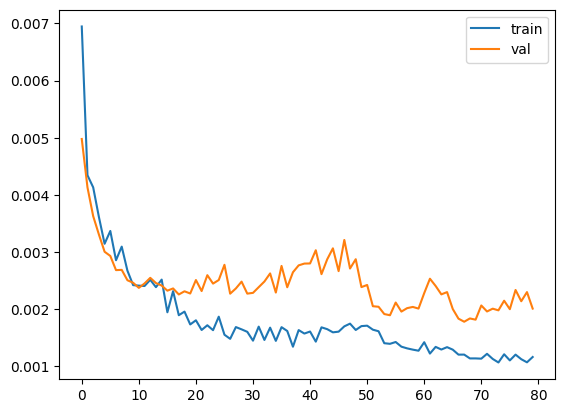

In [ ]:
# define parameters
epochs, batch_size = 80, 10  #was 70 30
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
n_outputs = 1 #train_y.shape[1]

# create model
# model=create_power_prediction_model_lstm1(128,7)
# model=create_power_prediction_model_cnn(128,7)
# model=create_power_prediction_model_linear(128,7)
# model=create_power_prediction_model_lstm2(n_timesteps, n_features,learning_rate=0.001)
model=create_power_prediction_model_cnn3(n_timesteps,n_features,0.001)
model.summary()

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()



## Evaluate the Model
Run inference on the multivariate, multi time period data.
Variables are rescaled by the maximum values.


In [ ]:
# # make a prediction

yhat = model.predict(test_X)
inv_yhat=yhat * feature_max['power']
inv_yhat=inv_yhat * (inv_yhat>0)
inv_y=test_y  * feature_max['power']

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

2/2 [==============================] - 0s 86ms/step
Test RMSE: 56.312
Test MAE: 41.783


Text(0, 0.5, 'Power (W)')

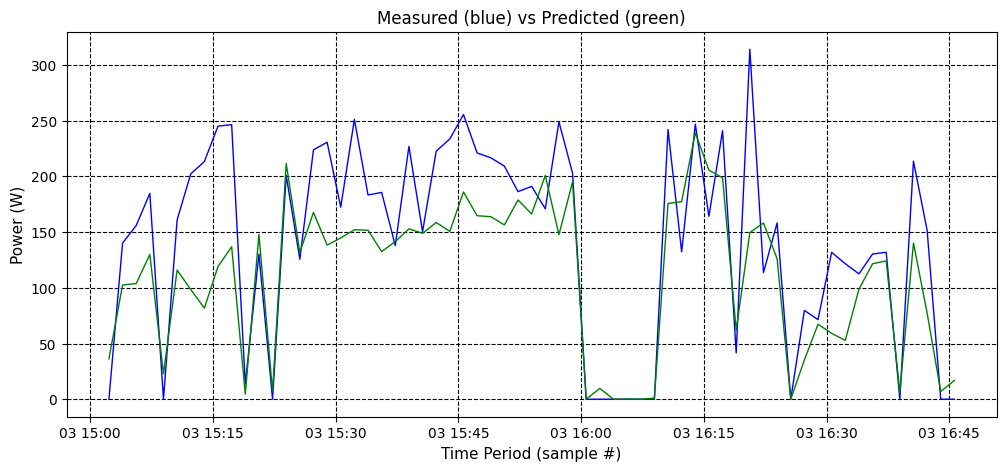

In [ ]:
fig1, ax1=plt.subplots(figsize=(12,5))
ax1.plot(test_ts, inv_y, linewidth=1, color='blue')
ax1.plot(test_ts, inv_yhat, linewidth=1, color='green')
ax1.set_title('Measured (blue) vs Predicted (green)')
ax1.tick_params(axis='both', which='major')
ax1.grid(which='major', color='k', linestyle='--')
# ax1.set_ylim([0,600])
ax1.set_xlabel('Time Period (sample #)', size=11)
ax1.set_ylabel('Power (W)', size=11)

[(0.0, 1000.0), (0.0, 1000.0)]

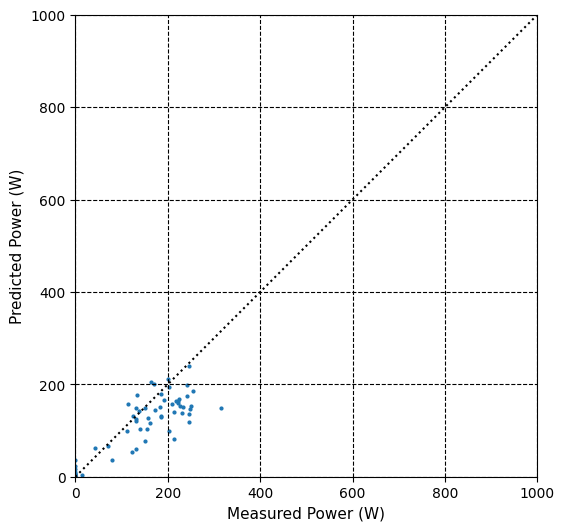

In [ ]:
plotlim=feature_max['power'] #1  #600
fig2 = plt.figure(figsize=(6,6)) # default is (8,6)
ax2 = fig2.add_subplot(111, aspect='equal')
ax2.scatter(inv_y, inv_yhat, s=4)
ax2.set_xlabel('Measured Power (W)', size=11)
ax2.set_ylabel('Predicted Power (W)', size=11)
ax2.grid(which='major', color='k', linestyle='--')
ax2.plot([0, plotlim], [0, plotlim], linestyle=':', color='k')
ax2.set(xlim=(0, plotlim), ylim=(0, plotlim))

In [ ]:
model.export('model')

Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8, 4), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137271701369984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271701862032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271702102336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271702094240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271702104624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271702107968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271700974832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271700975008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271700975888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137271700977824: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import tensorflow as tf
tflite_model = tf.lite.TFLiteConverter.from_saved_model("model").convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)